### Quick Start

The `LANfactory` package is a light-weight convenience package for training `likelihood approximation networks` (LANs) in torch (or keras), 
starting from supplied training data.

[LANs](https://elifesciences.org/articles/65074), although more general in potential scope of applications, were conceived in the context of sequential sampling modeling
to account for cognitive processes giving rise to *choice* and *reaction time* data in *n-alternative forced choice experiments* commonly encountered in the cognitive sciences.

In this quick tutorial we will use the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package to generate our training data using such a sequential sampling model (SSM). The use of of the `LANfactory` package is in no way bound to utilize this `ssms` package.

#### Install

To install the `ssms` package type,

`pip install git+https://github.com/AlexanderFengler/ssm_simulators`

To install the `LANfactory` package type,

`pip install git+https://github.com/AlexanderFengler/LANfactory`

Necessary dependency should be installed automatically in the process.

#### Basic Tutorial

In [ ]:
# Load necessary packages
import ssms
import lanfactory
import numpy as np
from copy import deepcopy
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from ssms.basic_simulators.simulator import simulator
import torch

wandb not available
wandb not available


#### Generate Training Data
First we need to generate some training data. As mentioned above we will do so using the `ssms` python package, however without delving into a detailed explanation
of this package. Please refer to the [basic ssms tutorial] (https://github.com/AlexanderFengler/ssm_simulators) in case you want to learn more.

In [2]:
RUN_SIMS = False
DEVICE = "cpu"
N_TRAIN_EPOCHS = 10

MODEL = "ddm"
OUT_FOLDER = Path("torch_nb_data") / "training_data"
MODEL_FOLDER = Path("torch_nb_data") / "torch_models" / "cpn"

N_DATA_FILES = 5

BATCH_SIZE = 1024


In [3]:
# MAKE CONFIGS

# Initialize the generator config (for MLP LANs)
generator_config = deepcopy(ssms.config.data_generator_config["lan"])
# Specify generative model (one from the list of included models mentioned above)
generator_config["model"] = MODEL
# Specify number of parameter sets to simulate
generator_config["n_parameter_sets"] = 10000
# Specify how many samples a simulation run should entail
generator_config["n_samples"] = 1000
# Specify folder in which to save generated data
generator_config["output_folder"] = OUT_FOLDER

# Make model config dict
model_config = ssms.config.model_config[MODEL]

/var/folders/gx/s43vynx550qbypcxm83fv56dzq4hgg/T/ipykernel_63494/60946343.py:4: DeprecationWarning: Accessing this configuration dict is deprecated and will be removed in a future version. Use `get_default_generator_config` instead.
  generator_config = deepcopy(ssms.config.data_generator_config["lan"])


In [4]:
# MAKE DATA
my_dataset_generator = ssms.dataset_generators.lan_mlp.data_generator(
    generator_config=generator_config, model_config=model_config
)

for i in range(N_DATA_FILES):
    print(i)
    training_data = my_dataset_generator.generate_data_training_uniform(save=True)

0
1
2
3
4


#### Prepare for Training

Next we set up dataloaders for training with pytorch. The `LANfactory` provides convenient helper functions for this.

The `make_train_valid_dataloaders` function handles:
- Splitting your data files into training and validation sets
- Creating the appropriate `DatasetTorch` objects
- Wrapping them in PyTorch `DataLoader` objects with sensible defaults

Under the hood, this uses the `DatasetTorch` class which handles batching and file loading internally.

In [ ]:
# MAKE DATALOADERS
TRAINING_TYPE = "cpn"

# List of datafiles
folder_ = Path("torch_nb_data/") / "cpn_mlp" / "training_data"
file_list_ = list(folder_.glob("*.pickle"))

# Create train and validation dataloaders with a single function call
torch_training_dataloader, torch_validation_dataloader, input_dim = lanfactory.trainers.make_train_valid_dataloaders(
    file_ids=file_list_,
    batch_size=BATCH_SIZE,
    network_type="cpn",
    train_val_split=0.9,
)

print(f"Training batches: {len(torch_training_dataloader)}")
print(f"Validation batches: {len(torch_validation_dataloader)}")
print(f"Input dimension: {input_dim}")

Now we define two configuration dictionariers,

1. The `network_config` dictionary defines the architecture and properties of the network
2. The `train_config` dictionary defines properties concerning training hyperparameters

Two examples (which we take as provided by the package, but which you can adjust according to your needs) are provided below.

In [6]:
# SPECIFY NETWORK CONFIGS AND TRAINING CONFIGS
network_config = lanfactory.config.network_configs.network_config_cpn
train_config = lanfactory.config.network_configs.train_config_cpn

train_config["cpu_batch_size"] = BATCH_SIZE
train_config["gpu_batch_size"] = BATCH_SIZE
train_config["n_epochs"] = N_TRAIN_EPOCHS

print("Network config: ")
print(network_config)

print("Train config: ")
print(train_config)

Network config: 
{'layer_sizes': [100, 100, 1], 'activations': ['tanh', 'tanh', 'linear'], 'train_output_type': 'logits'}
Train config: 
{'cpu_batch_size': 1024, 'gpu_batch_size': 1024, 'n_epochs': 10, 'optimizer': 'adam', 'learning_rate': 0.002, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'bcelogit', 'save_history': True}


We can now load a network, and save the configuration files for convenience.

In [ ]:
# LOAD NETWORK
# Option 1: Using the factory function (recommended)
net = lanfactory.trainers.TorchMLPFactory(
    network_config=deepcopy(network_config),
    input_dim=input_dim,
    network_type="cpn",
)

# Option 2: Direct instantiation (also works)
# net = lanfactory.trainers.TorchMLP(
#     network_config=deepcopy(network_config),
#     input_shape=input_dim,
#     network_type="cpn",
# )

# SAVE CONFIGS
lanfactory.utils.save_configs(
    model_id=MODEL + "_torch_",
    save_folder=Path("torch_nb_data/torch_models") / TRAINING_TYPE / MODEL,
    network_config=network_config,
    train_config=train_config,
)

Setting network type to "lan" or "cpn" based on train_output_type. 
Note: This is only a default setting, and can be overwritten by the network_type argument.
tanh
tanh
linear
Found folder:  torch_nb_data
Moving on...
Found folder:  torch_nb_data/torch_models
Moving on...
Did not find folder:  torch_nb_data/torch_models/cpn
Creating it...
Did not find folder:  torch_nb_data/torch_models/cpn/ddm
Creating it...
Saved network config
Saved train config


To finally train the network we supply our network, the dataloaders and training config to the `ModelTrainerTorchMLP` class, from `lanfactory.trainers`.

In [8]:
# TRAIN MODEL
model_trainer = lanfactory.trainers.ModelTrainerTorchMLP(
    model=net,
    train_config=train_config,
    train_dl=torch_training_dataloader,
    valid_dl=torch_validation_dataloader,
    allow_abs_path_folder_generation=False,
    pin_memory=True,
    seed=None,
)

# model_trainer.train_model(save_history=True, save_model=True, verbose=0)
model_trainer.train_and_evaluate(
    wandb_on=False,
    output_folder=Path("torch_nb_data/torch_models") / TRAINING_TYPE / MODEL,
    output_file_id=MODEL,
)
# LOAD MODEL

train_config is passed as dictionary: 

{'cpu_batch_size': 1024, 'gpu_batch_size': 1024, 'n_epochs': 10, 'optimizer': 'adam', 'learning_rate': 0.002, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'bcelogit', 'save_history': True}


/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_lanfactory/LANfactory/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


wandb not available
wandb not available
epoch: 0/10, batch: 0/45, batch_loss: 0.6693
Epoch took 0 / 10, took 8.347258806228638 seconds
wandb not available
wandb not available
epoch 0 / 10, validation_loss: 0.3904
wandb not available
wandb not available
epoch: 1/10, batch: 0/45, batch_loss: 0.3928
Epoch took 1 / 10, took 7.660676002502441 seconds
wandb not available
wandb not available
epoch 1 / 10, validation_loss: 0.3541
wandb not available
wandb not available
epoch: 2/10, batch: 0/45, batch_loss: 0.3509
Epoch took 2 / 10, took 7.549731969833374 seconds
wandb not available
wandb not available
epoch 2 / 10, validation_loss: 0.3444
wandb not available
wandb not available
epoch: 3/10, batch: 0/45, batch_loss: 0.3561
Epoch took 3 / 10, took 7.461402177810669 seconds
wandb not available
wandb not available
epoch 3 / 10, validation_loss: 0.3462
wandb not available
wandb not available
epoch: 4/10, batch: 0/45, batch_loss: 0.3507
Epoch took 4 / 10, took 7.4325032234191895 seconds
wandb not av

#### Load Model for Inference and Call

The `LANfactory` provides some convenience functions to use networks for inference after training. 
We can load a model using the `LoadTorchMLPInfer` class, which then allows us to run fast inference via either
a direct call, which expects a `torch.tensor` as input, or the `predict_on_batch` method, which expects a `numpy.array` 
of `dtype`, `np.float32`. 

In [ ]:
model_path = Path("torch_nb_data/torch_models") / TRAINING_TYPE / MODEL
network_file_path = next(model_path.glob("*state_dict*"))

# LoadTorchMLPInfer automatically calls eval() for inference mode
network = lanfactory.trainers.LoadTorchMLPInfer(
    model_file_path=network_file_path,
    network_config=network_config,
    input_dim=input_dim,
    network_type=TRAINING_TYPE,
)

tanh
tanh
linear


In [33]:
# Two ways to call the network

# Direct call --> need tensor input
direct_out = network(
    torch.from_numpy(np.array(ssms.config.model_config[MODEL]['default_params'], dtype=np.float32))
)
print("direct call out: ", direct_out)

# predict_on_batch method
predict_on_batch_out = network.predict_on_batch(
    np.array(ssms.config.model_config[MODEL]['default_params'], dtype=np.float32)
)
print("predict_on_batch out: ", predict_on_batch_out)

direct call out:  tensor([-0.7105])
predict_on_batch out:  [-0.71050066]


#### A peek into the first passage distribution computed by the network

We can compare the learned likelihood function in our `network` with simulation data from the underlying generative model.
For this purpose we recruit the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package again.

In [36]:
from ssms.basic_simulators.simulator import simulator
def plot_parameter_comparison(network,
                              simulator,
                              model, 
                              x_param, 
                              x_range,
                              alpha_param, 
                              alpha_range,
                              fixed_params=None, 
                              n_samples=5000,
                              n_x_points=2000,
                              n_alpha_points=10):
    """
    Plot network predictions vs simulations for varying parameters.
    
    Parameters:
    -----------
    network : object
        Trained network with predict_on_batch method
    simulator : object
        Simulator object with simulator method
    model : str
        Model name for simulator
    x_param : str
        Parameter to vary on x-axis (e.g., 'a', 'v', 'z', 't', 'deadline')
    x_range : tuple
        Range for x parameter (min, max)
    alpha_param : str
        Parameter to vary for different alpha levels (e.g., 'deadline', 'v', 'z', 't')
    alpha_range : tuple
        Range for alpha parameter (min, max)
    fixed_params : dict, optional
        Dictionary of fixed parameter values (e.g., {'v': 0.0, 'z': 0.5, 't': 0.5})
    n_samples : int, optional
        Number of simulation samples (default: 5000)
    n_x_points : int, optional
        Number of points for x-axis (default: 2000)
    n_alpha_points : int, optional
        Number of alpha levels (default: 20)
    
    Returns:
    --------
    tuple
        (network_predictions, simulation_results, x_values, alpha_values)
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    
    # Set default fixed parameters if none provided
    if fixed_params is None:
        fixed_params = {'v': 0.0, 'z': 0.5, 't': 0.5, 'deadline': 2.0}

    all_param_names = ssms.config.model_config[model.replace("_deadline", "")]['params']
    
    # Create base dataframe for simulator inputs
    data_sim = pd.DataFrame(
        np.zeros((n_x_points, len(all_param_names)), dtype=np.float32),
        columns=all_param_names,
    )

    # Set fixed parameters
    for param, value in fixed_params.items():
        data_sim[param] = value

    # Set x parameter range
    data_sim[x_param] = np.linspace(x_range[0], x_range[1], n_x_points)

    # Initialize network data
    data_network = deepcopy(data_sim)
    
    # Network predictions
    network_predictions = []
    
    # Simulations
    n_alpha = n_alpha_points
    n_x_sim = 40  # Number of simulation points for x-axis
    simulation_results = np.zeros((n_alpha, n_x_sim))
    
    # Generate alpha values
    alpha_values = np.linspace(alpha_range[0], alpha_range[1], n_alpha)
    x_sim_values = np.linspace(x_range[0], x_range[1], n_x_sim)
    x_network_values = np.linspace(x_range[0], x_range[1], n_x_points)

    data_network[x_param] = x_network_values
    # data_sim[x_param] = x_network_values

    for i, alpha_val in enumerate(alpha_values):
        # Set alpha parameter
        data_network[alpha_param] = alpha_val
        # data_nework[x_param] = x_sim_values
        # Get network predictions for all x values
        network_predictions.append(network.predict_on_batch(data_network.values.astype(np.float32)))
        
        # Run simulations for subset of x values
        for j, x_val in enumerate(x_sim_values):
            data_sim[x_param] = x_val
            data_sim[alpha_param] = alpha_val
            sim_out = simulator(model=model, theta=data_sim.values[0, :], n_samples=n_samples)
            simulation_results[i, j] = sim_out["choice_p"][0, 1]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Plot network predictions
    for i in range(n_alpha):
        alpha_val = alpha_values[i]
        plt.plot(
            x_network_values,
            np.exp(network_predictions[i]),
            color="black",
            label="network" if i == 0 else None,
            alpha=(i + 1) / n_alpha,
        )
        
        plt.plot(
            x_sim_values,
            simulation_results[i, :],
            color="red",
            label="simulations" if i == 0 else None,
            alpha=(i + 1) / n_alpha,
        )

    # Create a simple legend showing the alpha parameter range
    legend_elements = [
        mpatches.Patch(color='gray', alpha=0.2, label=f'{alpha_param}: {alpha_range[0]:.2f}'),
        mpatches.Patch(color='gray', alpha=0.8, label=f'{alpha_param}: {alpha_range[1]:.2f}')
    ]
    plt.legend(handles=legend_elements,
               title=f'{alpha_param} range',
               loc = "lower right")

    
    # plt.legend()
    plt.legend(handles=legend_elements, title="") #f'{alpha_param} range')  # This should replace it
    plt.title(f"Choice probability vs {x_param}")
    plt.xlabel(x_param)
    plt.ylabel("choice probability")
    plt.grid(True, alpha=0.3)
    plt.show()

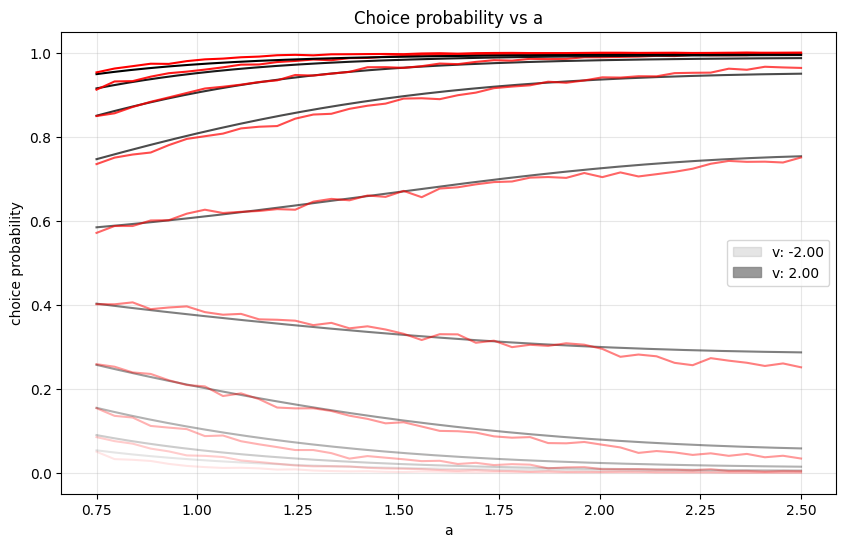

In [37]:
# Example usage:
plot_parameter_comparison(
    network=network,
    simulator=simulator,
    model=MODEL,
    x_param="a",
    x_range=(0.75, 2.5),
    alpha_param="v",
    alpha_range=(-2.0, 2.0),
    fixed_params={"z": 0.5, "t": 0.5}
)

We hope this package may be helpful in case you attempt to train [LANs](https://elifesciences.org/articles/65074) for your own research.

#### END